#**Solución examen 3**

|Quién | Fecha | Qué hizo |
| ---  | ---   | ---      |
|Juan Nicolás Ramírez, <jnramirezg@unal.edu.co> | 2024-09-27 | Creando código|

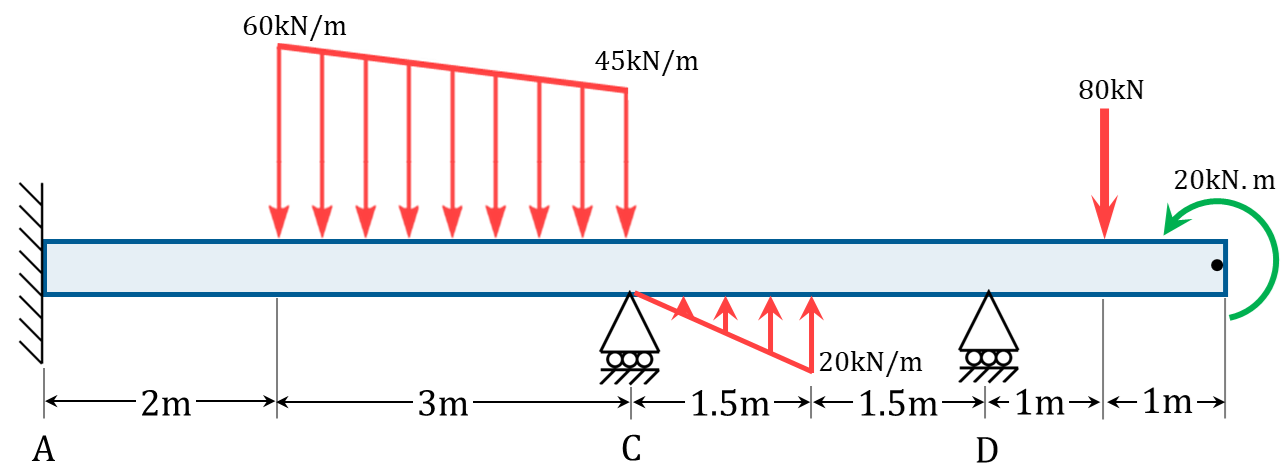

Dada la siguiente viga, considerando $E=25000MPa$:

* Calcular las reacciones en los apoyos.
* Graficar las fuerzas cortantes, momentos flectores, ángulos de giro, deflexiones usando la teoría de Euler-Bernoulli. Los gráficos deberán tener la concavidad, posición, grado y signos adecuados (no es necesario calcular la posición de los máximos/mínimos entre apoyos).
* Graficar la distribución del esfuerzo cortante en la posición en la que está su máximo absoluto (sólo se requieren indicar los valores de cambio de esfuerzo en la sección y el máximo absoluto).
* Graficar la distribución del esfuerzo normal en la posición en la que está su máxima tracción.
* Graficar la distribución del esfuerzo normal en la posición en la que está su máxima compresión.
* Calcular la deflexión en x=10m.


## Importar librerías y crear funciones

In [1]:
from sympy import lambdify, Piecewise, integrate, symbols, Eq, solve, diff
from numpy import sum, array, linspace, meshgrid, argmin, argmax
import matplotlib.pyplot as plt

In [2]:
# Función con la condición de Macaulay, a: punto de discontinuidad, g:grado
macaulay = lambda a, g : Piecewise(((x-a)**g, (a <= x)), (0, True))

In [3]:
def grafico_funcion_viga(x, f, titulo, momento=False):
    plt.figure(figsize=(10, 3))                   # Tamaño de la gráfica.
    plt.plot(x, f, 'r')                           # Gráfica de la función.
    plt.fill_between(x, f, color="lavenderblush") # Sombreado de la gráfica.
    plt.plot([0, max(x)], [0, 0], 'k')            # Eje x.
    plt.xlabel("Posición [m]")                   # Título del eje x.
    plt.ylabel(titulo)                            # Título del eje y.
    plt.xlim(0, max(x))                           # Límites en x del gráfico.
    if momento==True:             # Condición si la función es M(x).
        plt.gca().invert_yaxis()  # Invierte el eje y (función).
    plt.show()

def grafico_funcion_esfuerzo_seccion(y, f, titulo):
    plt.figure(figsize=(3, 6))                     # Tamaño de la gráfica.
    plt.plot(f, y, "r")                            # Gráfica de la función.
    plt.fill_betweenx(y,f, color="lavenderblush")  # Sombreado de la gráfica.
    plt.plot([0, 0], [min(y), max(y)], 'k')        # Eje y.
    plt.xlabel(titulo)                             # Título del eje x.
    plt.ylabel("Posición [m]")                    # Título del eje y.
    plt.ylim(min(yg), max(yg))                     # Límites en x del gráfico.
    plt.show()

def dibujar_esf_def(titulo, f, x, y):
    curvas = linspace(f.min(), f.max(), 20)  # Definimos 20 curvas de nivel.
    plt.figure(figsize=(12, 3))
    im = plt.pcolormesh(x, y, f, vmin=f.min(), vmax=f.max(), shading='gouraud', cmap='jet_r')
    # Se grafica la función con colores.
    plt.contour(x, y, f, levels=curvas, colors='k', linestyles='-', linewidths=0.7)
    plt.colorbar(im, aspect=5)       # Se crea una barra de color lateral.
    plt.ylabel(titulo, fontsize=18)  # Título.
    plt.xlim(x.min(), x.max())       # Límites en x del gráfico.
    plt.ylim(y.min(), y.max())       # Límites en y del gráfico.
    plt.show()

def area_poligono(puntos):
    # Calcular el área.
    area = 0.5 * sum(puntos[:-1, 0] * puntos[1:, 1] -
                     puntos[1:, 0] * puntos[:-1, 1])
    return area

def centroide_y_poligono(puntos):
    # Calcular el centroide y.
    cy = sum((puntos[:-1, 1] + puntos[1:, 1]) *
             (puntos[:-1, 0] * puntos[1:, 1] -
             puntos[1:, 0] * puntos[:-1, 1])) / (6 * area_poligono(puntos))
    return cy

def inercia_x_centroidal_poligono(puntos):
    # Calcular el centroide y
    cy = centroide_y_poligono(puntos)
    # Calcular el momento de inercia respecto al eje centroidal
    inercia = sum((puntos[:-1, 0] * puntos[1:, 1] -
                   puntos[1:, 0] * puntos[:-1, 1]) *
                  ((puntos[:-1, 1] - cy)**2 +
                   (puntos[:-1, 1] - cy) * (puntos[1:, 1] - cy) +
                   (puntos[1:, 1] - cy)**2)) / 12
    return inercia

# Datos de entrada

In [4]:
# Sección transversal
puntos = array([[85,0],[165,0],[200,200],[250,200],[250,250],[0,250],[0,200],[50,200],[85,0]])/1000
ci = centroide_y_poligono(puntos)  # [mm] Distancia del centroide a la fibra inferior.
cs = 0.25 - ci                        # [mm] Distancia del centroide a la fibra superior.
Icx = inercia_x_centroidal_poligono(puntos)

In [5]:
x, y = symbols("x, y")                           # Variables de posición.
C3, C4 = symbols("C3, C4")                       # Constantes de integración.
Ay, MA, By, Cy = symbols("A_y, M_A, B_y, C_y ")  # Reacciones

Se definen las ecuaciones de $b(y)$ y $Q(y)$:

In [6]:
b1  =(0.150-0.08)/(cs-0.05+ci)*(y+ci)+0.08
b2 =0.25
b = Piecewise((b1, (y >= -ci) & (y < cs-0.05)), (b2, (y>=cs-0.05)&(y<=cs)))#,(0, True))

In [7]:
Q = integrate(b*y, y) - integrate(b*y, y).subs(y,-ci)

In [8]:
E = 25e6 # [kPa] Módulo de elasticidad de la viga
L = 10     # [m]   Longitud de la viga.
I = Icx   # [m⁴]  Momento de inercia respecto a x.

Definimos a mano la ecuación del momento en el corte único:

In [9]:
M = (Ay*macaulay(0, 1)+By*macaulay(5, 1)+Cy*macaulay(8,1)
-80*macaulay(9, 1) - 45/2*macaulay(2, 2)+45/2*macaulay(5, 2)
+20/1.5/6*macaulay(5, 3)-20/2*macaulay(6.5, 2)-20/1.5/6*macaulay(6.5, 3)
-15/2*macaulay(2, 2)+15/3/6*macaulay(2, 3)-15/3/6*macaulay(5, 3)-MA*macaulay(0, 0))

In [10]:
t = integrate(M/(E*I), x) + C3  # [RAD] Ángulo de giro.
v = integrate(t,       x) + C4  # [m] deflexión con Euler-Bernoulli.

In [11]:
sol = solve([Eq(v.subs(x,0), 0),  # Despl vert en el apoyo x=0 es 0.
             Eq(t.subs(x,0), 0),  # Ang. giro  en el apoyo x=0 es 0.
             Eq(v.subs(x,5), 0),  # Despl vert en el apoyo x=5 es 0.
             Eq(v.subs(x,8), 0),  # Despl vert en el apoyo x=8 es 0.
             Eq(Ay+By+Cy-80-45*3-15/2*3+20/2*1.5,   0),                        # Sum fx=0
             Eq(MA-Ay*10+45*3*6.5+15/2*3*7-By*5-20/2*1.5*4-Cy*2+80*1+20,   0), # Sum M=0
             ],
            [Ay, MA, By, Cy, C3, C4 ])

# Cálculos

In [12]:
M = M.subs(sol)  # Reemplazamos la solución en la ec. de momentos.
t = t.subs(sol)  # Reemplazamos la solución en la ec. de giros.
v = v.subs(sol)  # Reemplazamos la solución en la ec. de deflexiones.

In [13]:
# Fuerza cortante.
V = diff(M,x)  # Es necesario hacerlo así, porque nunca fue definida previamente en el programa.

In [14]:
xi, yi = meshgrid(linspace(   0,  L, 1000),  # Dirección x.
                  linspace( -ci, cs, 1000))  # Dirección y, va de -ci hasta cs.

In [15]:
sx  = -M*y/I      # [N/mm^2] Esfuerzo normal.
txy =  V*Q/(I*b)  # [N/mm^2] Esfuerzo cortante.

In [16]:
V  = lambdify(x, V, "numpy")
M  = lambdify(x, M, "numpy")
t  = lambdify(x, t, "numpy")
v  = lambdify(x, v, "numpy")

sx  = lambdify((x,y),  sx, "numpy")
txy = lambdify((x,y), txy, "numpy")

In [17]:
xg = xi[0]    # Extraemos la información para funciones que sólo dependen de x.
yg = yi[:,0]  # Extraemos la información para funciones que sólo dependen de x.

# Gráficos


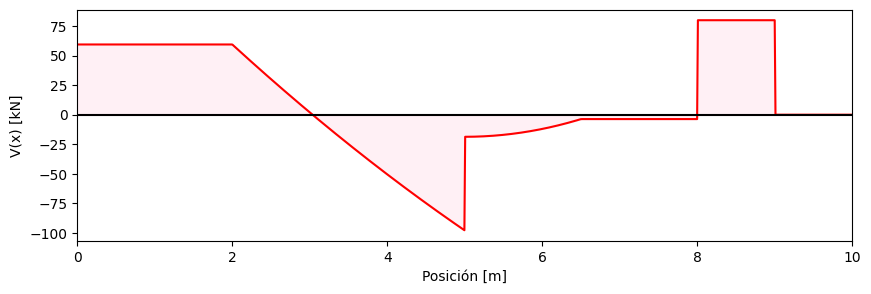

In [18]:
grafico_funcion_viga(xg, V(xg), "V(x) [kN]")

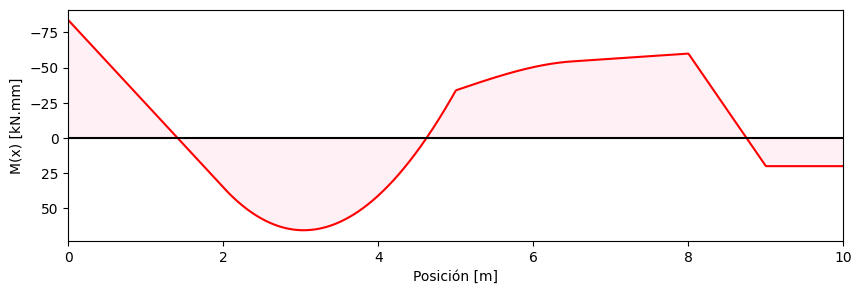

In [19]:
grafico_funcion_viga(xg, M(xg), "M(x) [kN.mm]", momento=True)

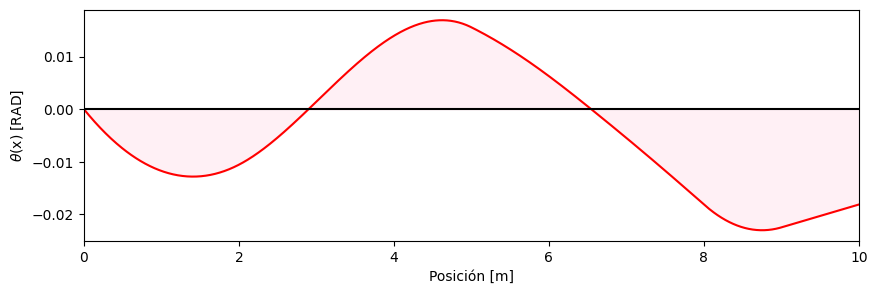

In [20]:
grafico_funcion_viga(xg, t(xg), r"$\theta$(x) [RAD]")

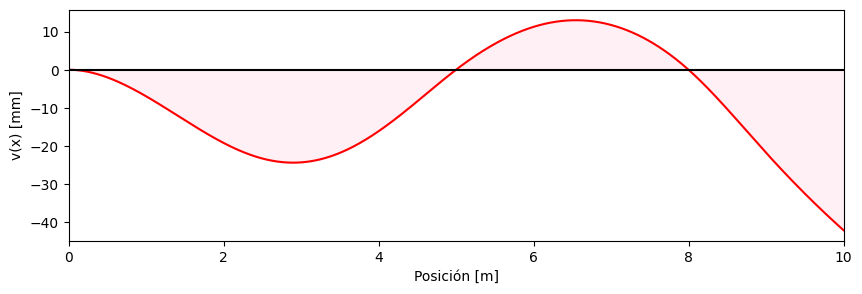

In [21]:
grafico_funcion_viga(xg, v(xg)*1000, "v(x) [mm]")

# Esfuerzos cortantes

In [22]:
x_Vmax = xg[argmax(abs(V(xg)))]
print(f"La fuerza cortante máxima absoluta es {round(max(abs(V(xg))),2)}N en la posición x={round(x_Vmax,1)}")

La fuerza cortante máxima absoluta es 97.81N en la posición x=5.0


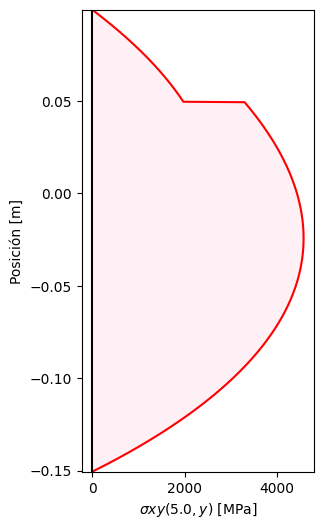

In [23]:
grafico_funcion_esfuerzo_seccion(yg, txy(x_Vmax,yg), rf"$\sigma xy({round(x_Vmax,1)},y)$ [MPa]")

In [24]:
# Cálculo por estática
-(2*ci/3*0.035*ci/2+ci/2*ci*0.08)*V(x_Vmax)/I/b1.subs(y,0)

4699.89748604780

In [25]:
txy(x_Vmax,0) # Cálculo por la integral en y=0 (Queda pendiente explicar por qué no coinciden)

4437.694739353423

In [26]:
max(txy(x_Vmax,yg)) # Cálculo por la integral, buscando el máximo

4580.820288708031

In [27]:
txy(x_Vmax,cs-0.0499999) # Cambio de sección por la integral.

1980.6671628250506

In [28]:
-(cs-0.05/2)*b2*0.05*V(x_Vmax)/I/b2 # Cambio de sección por concepto de estática.

1980.6697933071612

In [29]:
txy(x_Vmax,cs-0.0500001)  # Cambio de sección por la integral.

3301.1197229163304

In [30]:
-(cs-0.05/2)*b2*0.05*V(x_Vmax)/I/b1.subs(y,cs-0.05)  # Cambio de sección por concepto de estática.

3301.11632217860

# Esfuerzos normales

In [31]:
x_max_T_fs = xg[argmax(sx(xg,cs))]   # Máxima tracción fibra superior.
print(f"La máxima tracción de la fibra superior es: {round(sx(x_max_T_fs,cs)/1000,2)}MPa en la posición x={round(x_max_T_fs,2)}")

La máxima tracción de la fibra superior es: 45.29MPa en la posición x=0.0


In [32]:
x_max_C_fs = xg[argmin(sx(xg,cs))]   # Máxima compresión fibra superior.
print(f"La máxima compresión de la fibra superior es: {round(sx(x_max_C_fs,cs)/1000,2)}MPa en la posición x={round(x_max_C_fs,2)}")

La máxima compresión de la fibra superior es: -35.46MPa en la posición x=3.03


In [33]:
x_max_T_fi = xg[argmax(sx(xg,-ci))]  # Máxima tracción fibra inferior.
print(f"La máxima tracción de la fibra inferior es: {round(sx(x_max_T_fi,-ci)/1000,2)}MPa en la posición x={round(x_max_T_fi,2)}")

La máxima tracción de la fibra inferior es: 53.72MPa en la posición x=3.03


In [34]:
x_max_C_fi = xg[argmin(sx(xg,-ci))]  # Máxima tracción fibra inferior.
print(f"La máxima compresión de la fibra inferior es: {round(sx(x_max_C_fi,-ci)/1000,2)}MPa en la posición x={round(x_max_C_fi,2)}")

La máxima compresión de la fibra inferior es: -68.61MPa en la posición x=0.0


## Máxima tracción

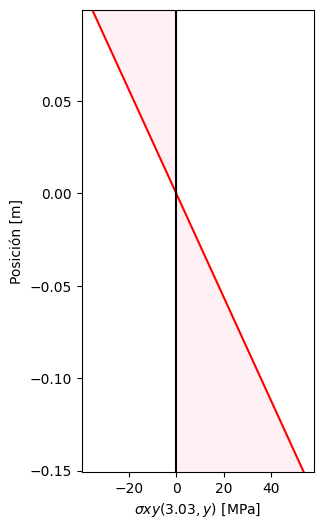

In [35]:
grafico_funcion_esfuerzo_seccion(yg, sx(x_max_T_fi,yg)/1000, rf"$\sigma xy({round(x_max_T_fi,2)},y)$ [MPa]")

## Máxima compresión

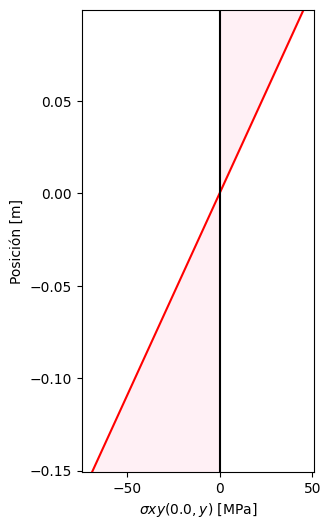

In [36]:
grafico_funcion_esfuerzo_seccion(yg, sx(x_max_C_fi,yg)/1000, rf"$\sigma xy({round(x_max_C_fi,2)},y)$ [MPa]")

# Deflexión en $x=10$

In [37]:
print(f"La deflexión en x=10 es {round(v(10)*1000,2)}m")

La deflexión en x=10 es -42.09m
